In [17]:
import ee
import geemap
import json
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

ee.Authenticate()
ee.Initialize(project='ee-yuxinchen118')

In [18]:
# Define center coordinates
center_lat = 43.5
center_lon = 11.0

# Convert kilometers to degrees (more accurate)
km_to_deg_lat = 1 / 111.32
km_to_deg_lon = 1 / (111.32 * math.cos(math.radians(center_lat)))

# Create a 25 km × 20 km rectangle (25 km east-west, 20 km north-south)
lat_extent = 20 * km_to_deg_lat
lon_extent = 25 * km_to_deg_lon

# Define the study area as a rectangle centered at the given point
tuscany_region = ee.Geometry.Rectangle([
    center_lon - lon_extent / 2,
    center_lat - lat_extent / 2,
    center_lon + lon_extent / 2,
    center_lat + lat_extent / 2
])
# 加载Sentinel-2影像
image_id = "20220418T100601_20220418T101300_T32TPP"
sentinel_image = ee.Image("COPERNICUS/S2_SR/" + image_id)

# 选择关键波段
selected_bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'] 
image = sentinel_image.select(selected_bands).clip(tuscany_region)

ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')
bsi = image.expression(
    '((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))', {
        'B11': image.select('B11'),
        'B4': image.select('B4'),
        'B8': image.select('B8'),
        'B2': image.select('B2')
    }
).rename('BSI')

composite = image.addBands([ndvi, ndwi, ndbi, bsi])
all_bands = selected_bands + ['NDVI', 'NDWI', 'NDBI', 'BSI']

In [20]:
# 读取训练和验证 CSV
train_df = pd.read_csv('Tuscany_pixels_training_data.csv')
valid_df = pd.read_csv('Tuscany_pixels_validation_data.csv')

# 提取波段名
all_bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7',
             'B8', 'B8A', 'B11', 'B12',
             'NDVI', 'NDWI', 'NDBI', 'BSI']

# 将 pandas DataFrame 转换为 GEE FeatureCollection
def df_to_fc(df):
    features = []
    for _, row in df.iterrows():
        geom = ee.Geometry.Point(json.loads(row['.geo'])['coordinates'])
        properties = {key: row[key] for key in all_bands + ['class']}
        features.append(ee.Feature(geom, properties))
    return ee.FeatureCollection(features)

train_fc = df_to_fc(train_df)
valid_fc = df_to_fc(valid_df)

In [21]:
# 从 composite 中提取样本用于训练
train_data = composite.sampleRegions(
    collection=train_fc,
    properties=['class'],
    scale=10,
    geometries=False
)

# 训练 Random Forest 分类器
classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=100,
    seed=42,
    minLeafPopulation=10,
    bagFraction=0.7
).train(
    features=train_data,
    classProperty='class',
    inputProperties=all_bands
)

# 应用分类器
classified = composite.classify(classifier)

In [23]:
# 设置颜色方案
color_scheme = {
    'trees': '#397D49',
    'grass': '#88B053',
    'crops': "#F58A07",
    'shrub': "#F0EA45",
    'built': '#C4281B'
}
classes = ['trees', 'grass', 'crops', 'shrub', 'built']
palette = [color_scheme[c] for c in classes]
Map = geemap.Map(center=[43.5, 11.0], zoom=10)
Map.addLayer(classified,
             {'min': 0, 'max': 4, 'palette': palette},
             'RF Classification')
Map.add_legend(title="Land Cover Types", legend_dict=color_scheme)
Map

Map(center=[43.5, 11.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [11]:
# 设置颜色方案
from pathlib import Path

def export_tuscany_classification(classified):
 

    # 2. 裁剪并转换为整数类型（用于 GeoTIFF 导出）
    classified_clipped = classified.clip(tuscany_region).byte()

    # 3. 创建导出任务
    task = ee.batch.Export.image.toDrive(
        image=classified_clipped,           # ✅ 原始分类图（非可视化）
        description='tuscany_rf_classification_raw',
        folder='Mapresult',       # Drive 文件夹名
        fileNamePrefix='Tuscany_RF_Classification',  # 文件名前缀
        region=tuscany_region,
        scale=30,
        crs='EPSG:4326',
        fileFormat='GeoTIFF',
        maxPixels=1e9
    )

    # 4. 启动任务
    task.start()
    print("✅ 导出任务已启动！请稍候检查 Google Drive 中的 EarthEngine_Exports 文件夹。")
    return task

# ✅ 调用函数
export_task = export_tuscany_classification(classified)


✅ 导出任务已启动！请稍候检查 Google Drive 中的 EarthEngine_Exports 文件夹。


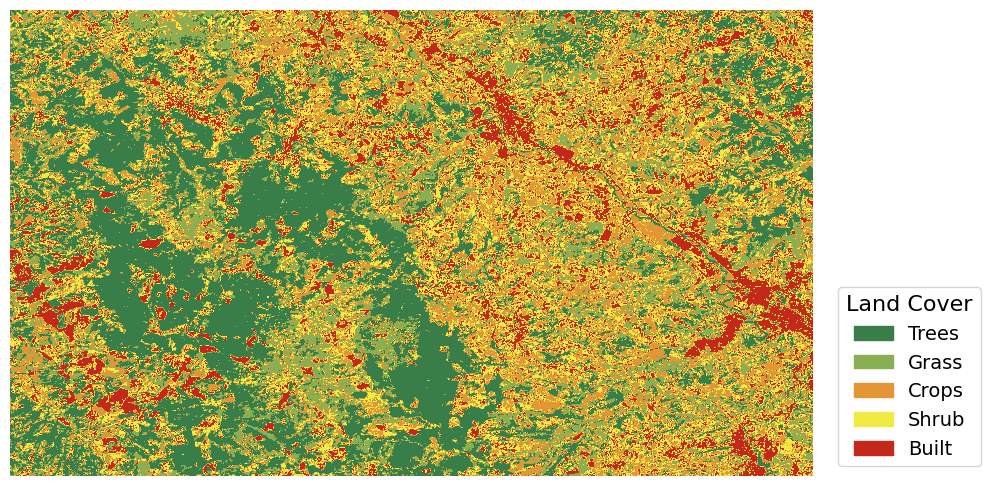

In [ ]:

import rasterio
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# 类别颜色定义
color_scheme = {
    'Trees': '#397D49',
    'Grass': '#88B053',
    'Crops': "#E49635",
    'Shrub': "#F0EA45",
    'Built': '#C4281B'
}
palette = list(color_scheme.values())
classes = list(color_scheme.keys())

# 读取 RF 分类 tif
with rasterio.open('Tuscany_RF_Classification.tif') as src:
    rf_image = src.read(1)

# 绘图
plt.figure(figsize=(10, 10))
cmap = plt.matplotlib.colors.ListedColormap(palette)
plt.imshow(rf_image, cmap=cmap, vmin=0, vmax=4)
plt.axis('off')

# 图例右下角外部
legend_patches = [Patch(color=palette[i], label=classes[i]) for i in range(len(classes))]
plt.legend(
    handles=legend_patches,
    title="Land Cover",
    loc='lower left',
    bbox_to_anchor=(1.02, 0),
    frameon=True,
    fontsize=14,
    title_fontsize=16
)

plt.tight_layout()
plt.savefig("Tuscany_RF_Classification_with_Legend.png", dpi=300, bbox_inches='tight')
plt.show()

Validation Accuracy: 0.8551020408163266
Confusion Matrix:
[[284   0   0   1   1]
 [  1 279   2  11   8]
 [  0   5 242  18  23]
 [  1  30  28 224  19]
 [  9   5  19  32 228]]


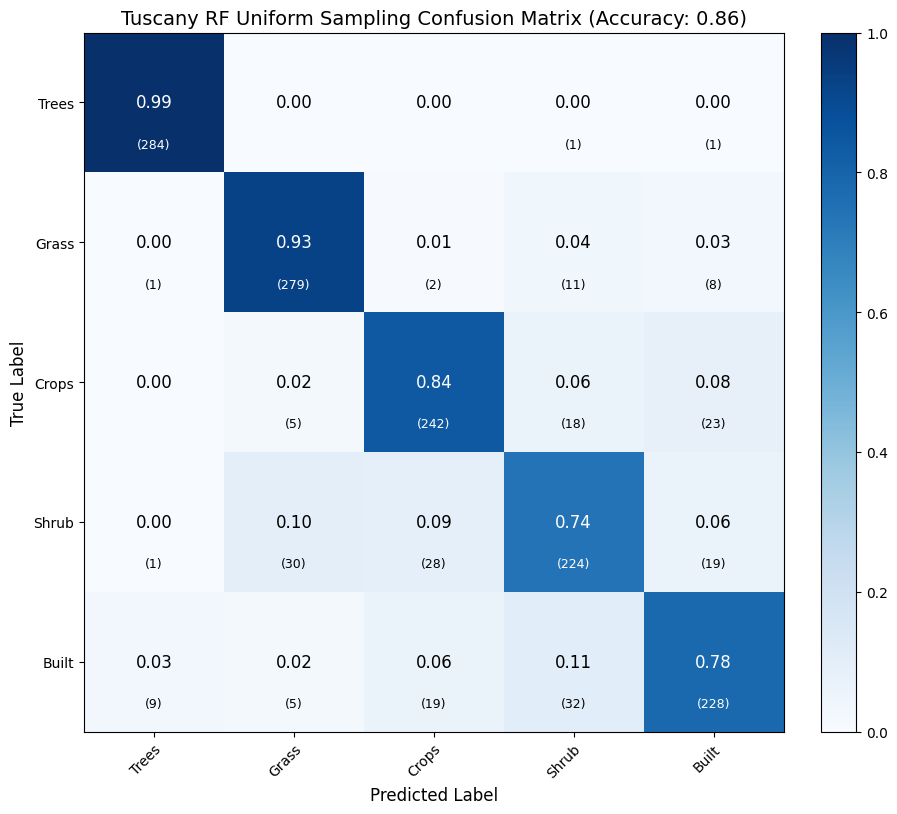

In [30]:
# 从 composite 中提取样本用于验证（注意 geometries=False）
val_data = composite.sampleRegions(
    collection=valid_fc,
    properties=['class'],
    scale=10,
    geometries=False
)

# 用训练好的分类器对验证集进行分类
validated = val_data.classify(classifier)

# 计算混淆矩阵
confusion_matrix = validated.errorMatrix('class', 'classification')

# 输出准确率
print('Validation Accuracy:', confusion_matrix.accuracy().getInfo())
print('Confusion Matrix:')
print(np.array(confusion_matrix.array().getInfo()))

# 可视化混淆矩阵（你的函数）
def plot_ee_confusion_matrix(confusion_matrix, class_names=None):
    cm_array = np.array(confusion_matrix.array().getInfo())
    accuracy = confusion_matrix.accuracy().getInfo()
    if class_names is None:
        n_classes = cm_array.shape[0]
        class_names = [str(i) for i in range(n_classes)]
    cm_normalized = np.zeros(cm_array.shape)
    for i in range(cm_array.shape[0]):
        row_sum = np.sum(cm_array[i, :])
        if row_sum > 0:
            cm_normalized[i, :] = cm_array[i, :] / row_sum
    
    fig, ax = plt.subplots(figsize=(10, 8))

    im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
    
    ax.set_title(f'Tuscany RF Uniform Sampling Confusion Matrix (Accuracy: {accuracy:.2f})', fontsize=14)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
   
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, f"{cm_normalized[i, j]:.2f}",
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > 0.5 else "black",
                    fontsize=12)
            if cm_array[i, j] > 0:
                ax.text(j, i + 0.3, f"({int(cm_array[i, j])})",
                        ha="center", va="center",
                        color="white" if cm_normalized[i, j] > 0.5 else "black",
                        fontsize=9)
    
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    return fig, ax

# 设置类别名称
class_names = ['Trees', 'Grass', 'Crops', 'Shrub', 'Built']

# 调用绘图
fig, ax = plot_ee_confusion_matrix(confusion_matrix, class_names)
plt.show()

In [12]:
def compute_accuracies(conf_matrix):
    cm = np.array(conf_matrix.array().getInfo())
    
    # 总样本数
    total = cm.sum()
    
    # 真实类总数（按行）
    actual = cm.sum(axis=1)
    
    # 预测类总数（按列）
    predicted = cm.sum(axis=0)
    
    # 准确分类数（对角线）
    correct = np.diag(cm)
    
    # Producer's Accuracy = 正确分类数 / 实际该类总数
    PA = correct / actual

    # User's Accuracy = 正确分类数 / 被预测为该类总数
    UA = correct / predicted

    # Overall Accuracy
    OA = correct.sum() / total
    
    # Kappa Coefficient
    expected = np.dot(actual, predicted) / (total ** 2)
    kappa = (OA - expected) / (1 - expected)

    return PA, UA, OA, kappa

# 计算 PA, UA, OA, Kappa
PA, UA, OA, kappa = compute_accuracies(confusion_matrix)

# 打印结果
print("📊 Accuracy Report")
print("Class\t\tPA\t\tUA")
for i, class_name in enumerate(class_names):
    print(f"{class_name:<10}\t{PA[i]:.4f}\t\t{UA[i]:.4f}")

print(f"\n✅ Overall Accuracy: {OA:.4f}")
print(f"✅ Kappa Coefficient: {kappa:.4f}")

📊 Accuracy Report
Class		PA		UA
Trees     	0.9930		0.9627
Grass     	0.9269		0.8746
Crops     	0.8403		0.8316
Shrub     	0.7417		0.7832
Built     	0.7782		0.8172

✅ Overall Accuracy: 0.8551
✅ Kappa Coefficient: 0.8189


In [40]:
import ee
import geemap
import math

# 初始化 Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-yuxinchen118')  # 替换为你的项目名

# ========== 设置中心和研究区域 ==========
center_lat = 43.5
center_lon = 11.0

# 千米转经纬度
km_to_deg_lat = 1 / 111.32
km_to_deg_lon = 1 / (111.32 * math.cos(math.radians(center_lat)))

# 构建25km × 20km 矩形区域
lat_extent = 20 * km_to_deg_lat
lon_extent = 25 * km_to_deg_lon

# Tuscany区域
tuscany_region = ee.Geometry.Rectangle([
    center_lon - lon_extent / 2,
    center_lat - lat_extent / 2,
    center_lon + lon_extent / 2,
    center_lat + lat_extent / 2
])

# ========== 加载 Sentinel-2 SR 图像并选择 RGB 波段 ==========
image_id = "20220418T100601_20220418T101300_T32TPP"
sentinel_image = ee.Image("COPERNICUS/S2_SR/" + image_id).clip(tuscany_region)

rgb_image = sentinel_image.select(['B4', 'B3', 'B2'])  # 红绿蓝

# ========== 下载到本地 ==========
geemap.download_ee_image(
    image=rgb_image,
    filename='tuscany_sentinel2_rgb.tif',
    region=tuscany_region,
    scale=10,
    crs='EPSG:4326'
)

print("✅ Sentinel-2 RGB 图像已成功下载为 'tuscany_sentinel2_rgb.tif'")


tuscany_sentinel2_rgb.tif: |          | 0.00/41.4M (raw) [  0.0%] in 00:00 (eta:     ?)

✅ Sentinel-2 RGB 图像已成功下载为 'tuscany_sentinel2_rgb.tif'


ERROR 1: _TIFFVSetField:/vsimem/decompress_0x159104c78.tif: Bad value 2 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x159104d18.tif: Bad value 2 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x159104ca0.tif: Bad value 2 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x1591053f8.tif: Bad value 2 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x159104cc8.tif: Bad value 2 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x159105498.tif: Bad value 2 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x159105448.tif: Bad value 2 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x159105470.tif: Bad value 2 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x159105178.tif: Bad value 2 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x1591053d0.tif: Bad value 2 for "ExtraSamples" tag
ERROR 1: _TIFFVSetField:/vsimem/decompress_0x15910

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# 打开图像
with rasterio.open('tuscany_sentinel2_rgb.tif') as src:
    img = src.read()  # 3 × H × W
    bounds = src.bounds

    # 获取图像实际长宽比（以 km 为单位）
    lat_range = bounds.top - bounds.bottom
    lon_range = bounds.right - bounds.left
    avg_lat = (bounds.top + bounds.bottom) / 2

    # 转换为公里
    km_per_deg_lat = 111.32
    km_per_deg_lon = 111.32 * math.cos(math.radians(avg_lat))
    lat_km = lat_range * km_per_deg_lat
    lon_km = lon_range * km_per_deg_lon
    aspect_ratio = lon_km / lat_km

# 设置显示大小
height_inches = 8
width_inches = height_inches * aspect_ratio

# 转置为 H × W × 3 并缩放到 0–1 范围（Sentinel-2 原始反射率 × 10000）
img = np.transpose(img, (1, 2, 0))  # H × W × 3
img = np.clip(img / 3000, 0, 1)     # 简单拉伸映射至 0–1（可视化效果较好）

# 绘图
plt.figure(figsize=(width_inches, height_inches), dpi=300)
plt.imshow(img, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
plt.axis('off')
plt.tight_layout()
plt.savefig("Tuscany_Sentinel2_RGB.png", dpi=300, bbox_inches='tight')
plt.show()
